In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from itertools import product
import colorsys
import networkx as nx

In [3]:
import numpy as np

num_zones = 16
num_trips = 20

width = int(200 * (num_zones**0.5))
height = int(200 * (num_zones**0.5))
num_horiz_roads = 4 * num_zones
num_vert_roads = 4 * num_zones

# Compute these
horiz_spacing = int(width / (num_horiz_roads - 1))
vert_spacing = int(height / (num_vert_roads - 1))

# Find the best approximate values for these variables that mean the roads are evenly spaced and fill the area
variables = list(
    product(
        range(width-5, width+6),
        range(height-5, height+6),
        range(num_horiz_roads-5, num_horiz_roads+6),
        range(num_vert_roads-5, num_vert_roads+6),
        range(horiz_spacing-5, horiz_spacing+6),
        range(vert_spacing-5, vert_spacing+6)
    )
)

def error_function(variables):
    width, height, num_horiz_roads, num_vert_roads, horiz_spacing, vert_spacing = variables
    horiz_error = abs(width - (num_horiz_roads - 1) * horiz_spacing) / width
    vert_error = abs(height - (num_vert_roads - 1) * vert_spacing) / height
    
    # Disqualify if total width or height taken up by roads spills over
    if (num_horiz_roads - 1) * horiz_spacing > width or (num_vert_roads - 1) * vert_spacing > height:
        return float('inf')
    
    return horiz_error + vert_error

best_variables = min(variables, key=error_function)
width, height, num_horiz_roads, num_vert_roads, horiz_spacing, vert_spacing = best_variables
print(width, height, num_horiz_roads, num_vert_roads, horiz_spacing, vert_spacing)

time_per_unit = 10
traffic_function = lambda: 0.9 + random.random() * 0.2

804 804 68 68 12 12


In [4]:
# Generate random colours
colours = []
transparency = 0.5
for i in range(num_zones):
    hue = i / num_zones
    lightness = 0.75
    saturation = 0.9
    rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
    hex_colour = "#{:02x}{:02x}{:02x}{:02x}".format(
        int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255), int(transparency * 255)
    )
    colours.append(hex_colour)
random.shuffle(colours)

# Generate random names
prefixes = [
    "North",
    "South",
    "East",
    "West",
    "Central",
    "Lower",
    "Upper",
    "Old",
    "New",
    "Inner",
    "Outer",
    "Upper",
    "Lower",
    "Little",
    "Big",
    "Saint",
    "King",
    "Queen",
    "Prince",
    "Princess",
    "Royal",
    "Grand",
]
suffixes = [
    "District",
    "Quarter",
    "Heights",
    "Village",
    "Park",
    "Square",
    "Gardens",
    "Town",
    "City",
    "Vista",
    "Valley",
    "Hills",
    "Meadows",
    "Forest",
    "Grove",
    "Lake",
    "River",
    "Bay",
    "Harbor",
    "Port",
    "Beach",
    "Cove",
]

names = [f"{prefix} {suffix}" for prefix, suffix in product(prefixes, suffixes)]
random.shuffle(names)
names = names[: num_zones]

print("Example names:")
for name in names[:5]:
    print("- ", name)

Example names:
-  Lower Park
-  Royal Quarter
-  Big Beach
-  Upper Lake
-  New Hills


In [5]:
def visualise(street_graph, zones, trips=[]):
    plt.figure(figsize=(15, 10))

    # Background
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_facecolor("#f8f9fa")

    # Draw the street network
    for u, v in street_graph.edges():
        u_data = street_graph.nodes[u]
        v_data = street_graph.nodes[v]
        plt.plot(
            [u_data["x"], v_data["x"]],
            [u_data["y"], v_data["y"]],
            color="#777777",
            linewidth=1,
        )

    # Draw all zones
    for zone in zones:
        rect = patches.Rectangle(
            (zone["x"], zone["y"]),
            zone["width"],
            zone["height"],
            linewidth=1,
            edgecolor="#333333",
            facecolor=zone["colour"],
            alpha=0.5,
        )
        plt.gca().add_patch(rect)
        plt.text(
            zone["x"] + zone["width"] / 2,
            zone["y"] + zone["height"] / 2,
            zone["name"],
            ha="center",
            va="center",
            fontweight="bold",
        )

    # Draw the specific routes
    for trip in trips:
        route = trip["route"]
        route_colour = f"#{random.randint(0, 0xFFFFFF):06x}"
        for j in range(len(route) - 1):
            u = route[j]
            v = route[j + 1]
            u_data = street_graph.nodes[u]
            v_data = street_graph.nodes[v]
            plt.plot(
                [u_data["x"], v_data["x"]],
                [u_data["y"], v_data["y"]],
                color=route_colour,
                linewidth=2,
            )

    plt.tight_layout()
    plt.show()

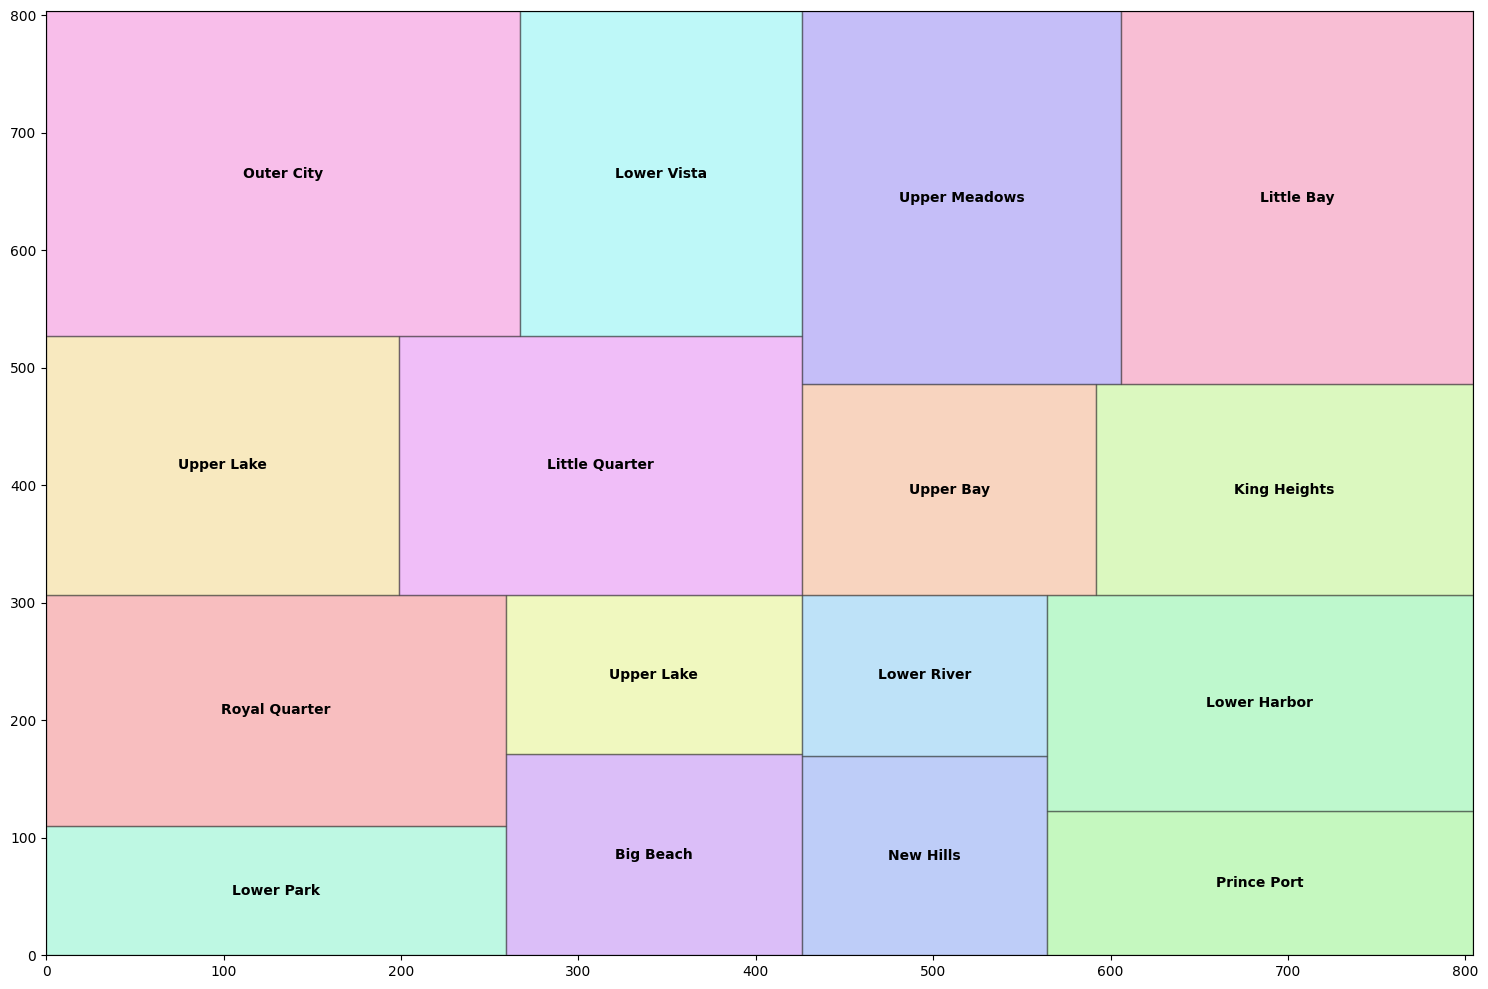

In [6]:
# Generate random zones
min_size = min(width, height) // (num_zones // 2)

def split_area(x, y, width, height, remaining_zones):
    if remaining_zones <= 1 or min(width, height) < min_size:
        return [{"x": x, "y": y, "width": width, "height": height}]

    split_vertically = width > height
    split_range = (width if split_vertically else height) // 3
    split_pos = random.randint(split_range, 2 * split_range)

    first_half = remaining_zones // 2
    second_half = remaining_zones - first_half

    if split_vertically:
        return split_area(x, y, split_pos, height, first_half) + split_area(
            x + split_pos, y, width - split_pos, height, second_half
        )
    else:
        return split_area(x, y, width, split_pos, first_half) + split_area(
            x, y + split_pos, width, height - split_pos, second_half
        )

base_zones = split_area(0, 0, width, height, num_zones)
zones = [
    {
        "id": i,
        "x": z["x"],
        "y": z["y"],
        "width": z["width"],
        "height": z["height"],
        "name": name,
        "colour": colour,
    }
    for i, (z, name, colour) in enumerate(
        zip(base_zones, names, colours)
    )
]

visualise(nx.Graph(), zones)

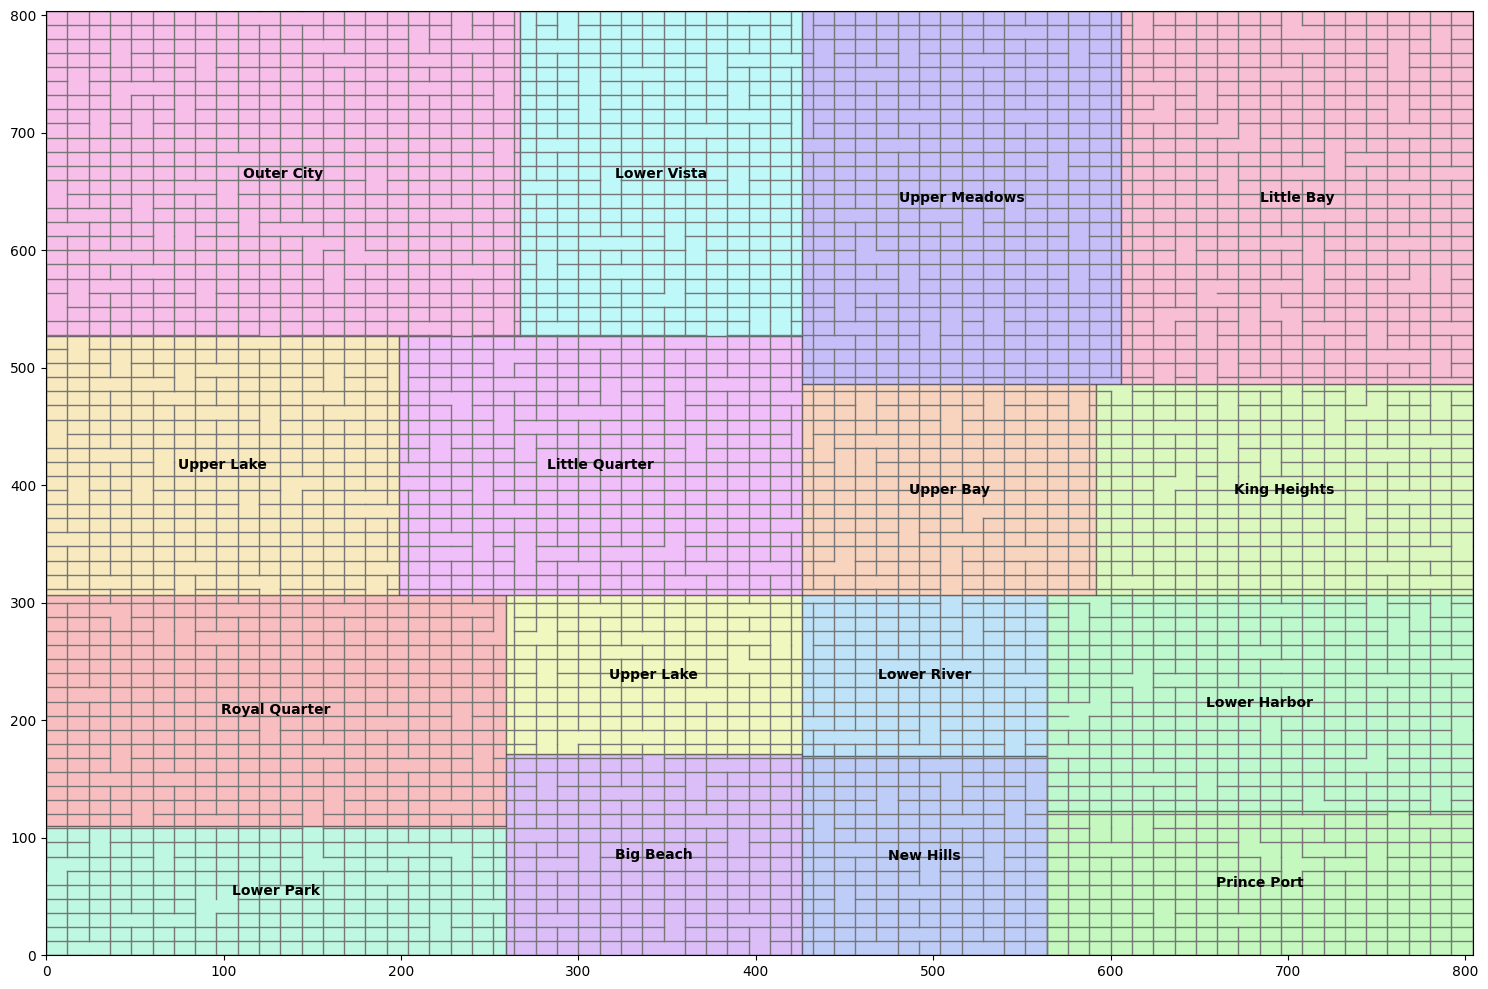

In [7]:
# Generate the street network
street_graph = nx.Graph()

# Create grid nodes
for i in range(num_horiz_roads + 1):
    for j in range(num_vert_roads + 1):
        x = i * horiz_spacing
        y = j * vert_spacing
        node_id = f"{x},{y}"
        street_graph.add_node(node_id, x=x, y=y)

# Connect horizontally
for i in range(num_horiz_roads):
    for j in range(num_vert_roads + 1):
        x1 = i * horiz_spacing
        x2 = (i + 1) * horiz_spacing
        y = j * vert_spacing
        node1 = f"{x1},{y}"
        node2 = f"{x2},{y}"
        distance = horiz_spacing
        street_graph.add_edge(node1, node2, weight=distance)

# Connect vertically
for i in range(num_horiz_roads + 1):
    for j in range(num_vert_roads):
        x = i * horiz_spacing
        y1 = j * vert_spacing
        y2 = (j + 1) * vert_spacing
        node1 = f"{x},{y1}"
        node2 = f"{x},{y2}"
        distance = vert_spacing
        street_graph.add_edge(node1, node2, weight=distance)

# Remove 5% of edges randomly
edges = list(street_graph.edges())
num_to_remove = int(len(edges) * 0.05)
edges_to_remove = random.sample(edges, num_to_remove)
street_graph.remove_edges_from(edges_to_remove)

visualise(street_graph, zones)

In [8]:
def is_point_in_zone(point, zone):
    x, y = point
    return (
        x >= zone["x"]
        and x <= zone["x"] + zone["width"]
        and y >= zone["y"]
        and y <= zone["y"] + zone["height"]
    )

In [9]:
# Precompute street points inside each zone
def get_street_points_in_zone(zone_id):
    zone = next((z for z in zones if z["id"] == zone_id), None)
    if not zone:
        return []

    points_in_zone = []
    for node_id, data in street_graph.nodes(data=True):
        if is_point_in_zone((data["x"], data["y"]), zone):
            points_in_zone.append({"x": data["x"], "y": data["y"], "id": node_id})

    return points_in_zone

points_in_zone = {
    zone["id"]: get_street_points_in_zone(zone["id"])
    for zone in zones
}


Example trips:
- New Hills to Royal Quarter in 51.12 units
- Lower Park to Little Quarter in 72.20 units
- Upper Lake to Upper Lake in 3.42 units
- Lower Harbor to Lower Park in 76.76 units
- Upper Meadows to Upper Meadows in 24.49 units


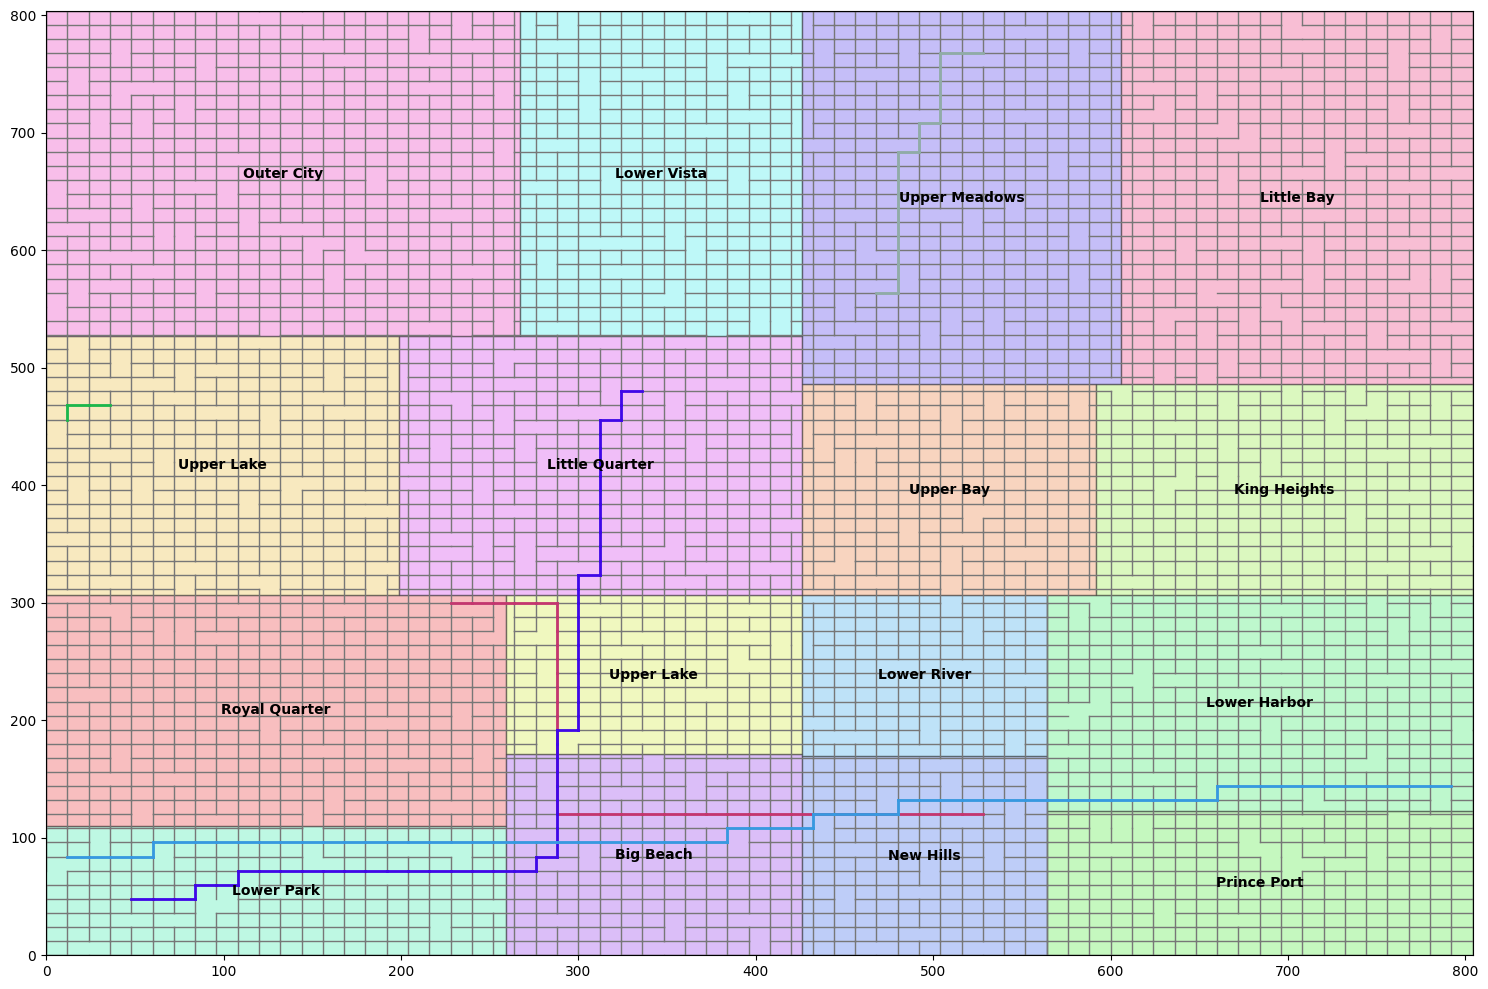

In [10]:
# Generate trips
trips = []

for i in range(num_trips):
    start_zone_index = random.randint(0, len(zones) - 1)
    start_zone = zones[start_zone_index]

    end_zone_index = random.randint(0, len(zones) - 1)
    end_zone = zones[end_zone_index]

    start_point = random.choice(points_in_zone[start_zone["id"]])
    end_point = random.choice(points_in_zone[end_zone["id"]])

    route = nx.shortest_path(street_graph, start_point["id"], end_point["id"], weight="weight")
    distance = nx.shortest_path_length(street_graph, start_point["id"], end_point["id"], weight="weight")
    base_time = distance / time_per_unit
    travel_time = traffic_function() * base_time

    trips.append(
        {
            "id": i,
            "start_zone_id": start_zone["id"],
            "start_zone_name": start_zone["name"],
            "end_zone_id": end_zone["id"],
            "end_zone_name": end_zone["name"],
            "travel_time": travel_time,
            "real_start_point": dict(start_point),
            "real_end_point": dict(end_point),
            "estimated_start_point": None,
            "estimated_end_point": None,
            "route": route,
        }
    )

print("Example trips:")
for trip in trips[:5]:
    print(
        f"- {trip['start_zone_name']} to {trip['end_zone_name']} in {trip['travel_time']:.2f} units"
    )

visualise(street_graph, zones, trips[:5])